## Homework 3:
### For this assignment, I tested many models and feature engineering techniques. In the first part, I show how I selected the features/genes and how I can further manipulate the data with dimensionality reduction. In the second part, I added information from external datasets, specifically the RACS and Cell Line datasets. In the third part, I developing a scoring to rank drug sensitivity for each cell line.

## Part 1a: 
### Load and preprocess the data.

In [46]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

data_dir = './MLiC-Homework'

In [48]:
# Import the full gene expression data
gene_exp_df = pd.read_csv(os.path.join(data_dir, 'Cell_line_RMA_proc_basalExp_transposed.tsv'), header = 0,index_col=0, skiprows=[1], sep='\t')
gene_exp_df.index.rename('COSMIC_ID', inplace=True)
gene_exp_df.index = gene_exp_df.index.map(lambda x: x.split('.')[1])
gene_exp_df.index = gene_exp_df.index.astype('int64')

full_gene = gene_exp_df
full_gene.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00526,PPY2,Unnamed: 17730,Unnamed: 17731,KRT18P55,Unnamed: 17733,POLRMTP1,UBL5P2,TBC1D3P5,Unnamed: 17737
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
906826,7.632023,2.964585,10.379553,3.614794,3.380681,3.324692,3.566350,8.204530,5.235118,5.369039,...,6.786925,2.997054,3.109774,7.882377,3.331134,2.852537,3.130696,9.986616,3.073724,7.284733
687983,7.548671,2.777716,11.807341,4.066887,3.732485,3.152404,7.827172,6.616972,5.809264,7.209653,...,5.317911,3.263745,3.059424,8.681302,2.992611,2.776771,3.260982,9.002814,3.000182,8.504804
910927,8.712338,2.643508,9.880733,3.956230,3.236620,3.241246,2.931034,8.191246,5.426841,5.120747,...,3.143006,3.112145,2.930254,8.707886,2.886574,2.685307,3.176239,9.113243,2.916274,7.059092
1240138,7.797142,2.817923,9.883471,4.063701,3.558414,3.101247,7.211707,8.630643,5.617714,4.996434,...,3.153896,3.151576,2.850726,7.872535,3.812119,3.436412,3.074432,9.958284,3.256500,7.318125
1240139,7.729268,2.957739,10.418840,4.341500,3.840373,3.001802,3.375422,8.296950,5.669418,4.180205,...,3.652660,2.918475,2.849537,8.945953,3.412586,2.951270,3.213545,9.938978,3.396126,7.726867


### In the given normalized dataset there are 17737 genes. Many of these genes are uninformative because there is very little variance across cell lines. Thus, we need to determine a variance threshold such that genes with a variance lower than the threshold are removed from the data. For the purposes of the assignment, we test multiple variances and see how they affect model performance. I use a simple linear model, ridge regression as the model. 

Drug: 171
Drug: 1005
Drug: 290
Drug: 235
Drug: 305
Drug: 263
Drug: 1194
Drug: 345
Drug: 1375
Drug: 1037
Features below variance of 0.1 removed: 0.330338359755036
Features below variance of 0.3 removed: 0.3373802648186358
Features below variance of 0.5 removed: 0.35019882531931257
Features below variance of 0.7 removed: 0.3563095492960514
Features below variance of 1.0 removed: 0.3581216648930875
Features below variance of 1.2 removed: 0.35271980606819947
Features below variance of 1.5 removed: 0.33814701023735005
Features below variance of 2.0 removed: 0.3264947421222291
Features below variance of 2.5 removed: 0.329346947912169
Features below variance of 3.0 removed: 0.29640077519523167


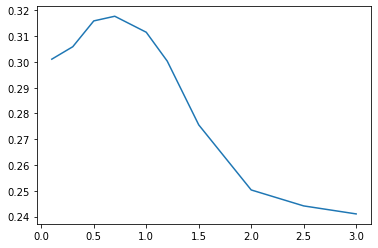

In [51]:
from sklearn.feature_selection import VarianceThreshold
scoring = 'r2'
model = Ridge
param_grid = {'alpha':np.logspace(3,6,15)}

drugs = list(ic50_df[ic50_df.COSMIC_ID == 924100].DRUG_ID.sample(n=10, random_state =0))
variances = {}
for drug in drugs:
    print(f'Drug: {drug}')
    small_ic50 = ic50_df[ic50_df.DRUG_ID == drug]
    small_merged = small_ic50.merge(gene_exp_df, left_on = 'COSMIC_ID', right_on = 'COSMIC_ID', how='left')
    small_merged.drop('COSMIC_ID', axis=1, inplace=True)
    small_merged.dropna(axis=0, how='any',inplace=True)
    y = small_merged.LN_IC50
    X = small_merged.iloc[:,1:]
    for var in [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0]:
        
        
        sel = VarianceThreshold(threshold = var)
        X = sel.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=0)
        clf = GridSearchCV(model(), param_grid, scoring=scoring, cv=5, n_jobs=-1)
        clf.fit(X_train, y_train)
        if var in variances:
            variances[var].append(clf.best_score_)
        else: 
            variances[var]=[clf.best_score_]

        
for k,v in variances.items():
    print(f'Features below variance of {k} removed: {np.mean(v)}')
    
datapts = list(zip(*(variances.values())))

np.var(datapts, axis=1)
datapts = datapts[:3]+datapts[5:]

plt.plot(variances.keys(), np.mean(datapts, axis=0))

### From this analysis, the graph begins to plateau around 0.5, so we will use this as the variance threshold moving forward. The number of features/genes reduces from 17737 to 6136.

In [52]:
# Import the IC50 data. These will be the labels for the samples
ic50_df = pd.read_csv(os.path.join(data_dir, 'v17_fitted_dose_response.csv'), usecols = ['COSMIC_ID', 'DRUG_ID', 'LN_IC50'], dtype={'COSMIC_ID':np.int64})
ic50_df.head()


,COSMIC_ID,DRUG_ID,LN_IC50
0,924100,1026,0.72
1,924100,1028,2.66
2,924100,1029,3.34
3,924100,1030,5.16
4,924100,1031,-4.33


In [53]:
def merge(threshold, gene_data):
    '''Merge gene data (features) to the IC50 data (labels)'''
    if threshold == 0:
        x = gene_data
    else:
        x = gene_data.loc[:,~(gene_data.var()<threshold)]
    merged = ic50_df.merge(x, left_on = 'COSMIC_ID', right_on = 'COSMIC_ID', how='left')
    merged.drop('COSMIC_ID', axis=1, inplace=True)
    merged.dropna(axis=0, how='any',inplace=True)
    return merged

In [ ]:
# Dataframe with both labels and features (validation threshold of 0.5)
xs_merged = merge(0.5, full_gene)

In [277]:
xs_merged.shape

(213650, 6136)

In [55]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


def fully_train_and_evaluate(scoring, data, model, param_grid, drugs):
    '''Fine-tuning, training, and evaluating all-in-one'''
    test_scores = {}
    train_scores = {}
    best_params = {}
    clf_test_scores = {}

    for i, drug in enumerate(drugs):
#         print(f'Drug {i+1}, Drug id {drug}')
        test_scores[drug] = []
        train_scores[drug] = []
        best_params[drug] = []
        clf_test_scores[drug] = []
        
        d = data[data.DRUG_ID == drug].drop('DRUG_ID', axis = 1).reset_index(drop =True)
        X = d.iloc[:,1:]
        y = d.LN_IC50
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=0)
        
        clf = GridSearchCV(model, param_grid, scoring='r2', cv=5, n_jobs=-1)
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test)
#         print(clf.best_score_)
        train_scores[drug]=clf.best_score_
        test_scores[drug]=best_model.score(X_test, y_test)

        mean = y.mean()
        std = y.std()
        
        def label(value):
            if value < mean - std:
                return 's'
            elif value > mean + std:
                return 'r'
            else:
                return 'i'
        
        clf_y_pred = list(map(label, y_pred))
        clf_y_test = list(map(label, y_test))
        clf_test_scores[drug]=(accuracy_score(clf_y_test, clf_y_pred))
        
    return train_scores, test_scores, clf_test_scores


### Note: For the classification portion of this part of the assignment, I determine thresholds for each class (Sensitive, Intermediate, Resistant). Then, I use these threshold to map the regression prediction to a class. The thresholds are determined by the mean and standard deviation of the IC50 values. If the IC50 value is less than one standard deviation below the mean, the cell line is sensitive to the drug. If the IC50 value is more than one standard deviation above the mean, the cell line is resistant. Otherwise, the cell line is considered Intermediate.

## Part 1b: 
### In order to determine which model to use for this problem, I tested many models, including Ridge Regression, Support Vector Regression, ElasticNet, RandomForestRegression, and MLPRegressor; however, time and time again, the Ridge Regression model performed better on average. Below I show the test for SVR and Ridge Regression.

In [58]:
drugs = list(ic50_df.DRUG_ID.unique()[:10])
models = {'svr':(SVR(), {'C':[1, 10], 'epsilon': [0.1, 0.2, 0.4, 0.6, 0.8, 1]}),
          'ridge': (Ridge(), {'alpha': np.logspace(3, 6, 15)})}
# models = {'ridge': (Ridge(), {'alpha': np.logspace(3, 6, 15)})}

train = {}
reg_test = {}
clf_test = {}

for j, model in models.items():
    train_scores, test_scores, clf_test_scores = fully_train_and_evaluate('r2', xs_merged, model[0], model[1], drugs)
    train[j] = train_scores
    reg_test[j] = test_scores
    clf_test[j] = clf_test_scores

In [66]:
svr_test = np.mean(list(reg_test['svr'].values()))
r_test = np.mean(list(reg_test['ridge'].values()))
svr_clf = np.mean(list(clf_test['svr'].values()))
r_clf = np.mean(list(clf_test['ridge'].values()))

print(f"On average across the drug models, the r2 value for SVR is {svr_test}")
print(f"On average across the drug models, the r2 value for Ridge is {r_test}")

print(f"On average across the drug models, the accuracy for SVR is {svr_clf}")
print(f"On average across the drug models, the accuracy for Ridge is {r_clf}")


On average across the drug models, the r2 value for SVR is 0.26346361045007477
On average across the drug models, the r2 value for Ridge is 0.27947337796140204
On average across the drug models, the accuracy for SVR is 0.7206548347613219
On average across the drug models, the accuracy for Ridge is 0.722405820753434


### We observe that Ridge performs slightly better than SVR

### We will use Ridge regression and for each drug model, we will do a grid search to find the optimal alpha for the model.

In [67]:
drugs = list(ic50_df.DRUG_ID.unique())
model=(Ridge(), {'alpha': np.logspace(3, 6, 15)})

xs_train, xs_test, xs_clf = fully_train_and_evaluate('r2', xs_merged, model[0], model[1], drugs)

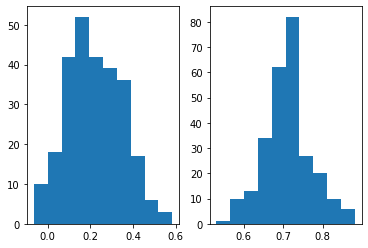

In [76]:
# pd.DataFrame(list(xs_test.values())).hist()
def plot_histograms(lst1, lst2):
    plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
    plt.hist(lst1)
    plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
    plt.hist(lst2)
    plt.show()
    
plot_histograms(list(xs_test.values()), list(xs_clf.values()))

### Above is a distribution of the evaluation metrics across all drug models. Left is for the regression metric r2. Right is accuracy (for the classification module we integrated into our train and evaluate function.

### Sometimes the model performance can be improved with dimensionality reduction on the input features. PCA is a dimensionality reduction technique which does a linear mapping of the data to a lower dimension in a way that maximizes the variance of the data.

In [74]:
xs_gene = full_gene.loc[:,~(full_gene.var()<0.5)]

In [75]:
pca = PCA(n_components=500)
xs_pca = pca.fit_transform(X=xs_gene)


xs_pca = pd.DataFrame(xs_pca)
xs_pca.index = gene_exp_df.index

xs_pca_merged = merge(0, xs_pca)
drugs = list(ic50_df.DRUG_ID.unique())
model=(Ridge(), {'alpha': np.logspace(3, 6, 15)})
pcatrain_scores, pcatest_scores, pcaclf_test_scores = fully_train_and_evaluate('r2', xs_pca_merged, model[0], model[1], drugs)

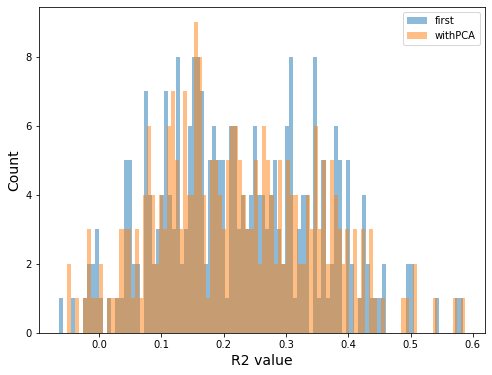

Average r2 across all 265 drug models: 0.22266750866444052
Average r2 across all 265 drug models with reduced data: 0.22012428738797846


In [85]:
# plot_histograms(list(pcatest_scores.values()), list(pcaclf_test_scores.values()))

plt.figure(figsize=(8,6))
plt.hist(list(xs_test.values()), bins=100, alpha=0.5, label="first")
plt.hist(list(pcatest_scores.values()), bins=100, alpha=0.5, label="withPCA")
plt.xlabel("R2 value", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()
print(f'Average r2 across all 265 drug models: {np.mean(list(xs_test.values()))}')
print(f'Average r2 across all 265 drug models with reduced data: {np.mean(list(pcatest_scores.values()))}')
      

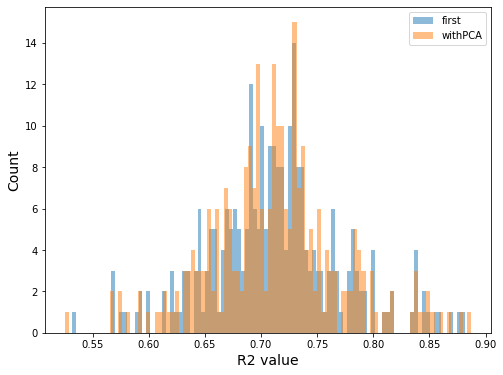

Average accuracy across all 265 drug models: 0.7121669420813148
Average accuracy across all 265 drug models with reduced data: 0.7124761061082282


In [88]:
# plot_histograms(list(pcatest_scores.values()), list(pcaclf_test_scores.values()))

plt.figure(figsize=(8,6))
plt.hist(list(xs_clf.values()), bins=100, alpha=0.5, label="first")
plt.hist(list(pcaclf_test_scores.values()), bins=100, alpha=0.5, label="withPCA")
plt.xlabel("R2 value", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()
print(f'Average accuracy across all 265 drug models: {np.mean(list(xs_clf.values()))}')
print(f'Average accuracy across all 265 drug models with reduced data: {np.mean(list(pcaclf_test_scores.values()))}')
      

In [97]:


def print_top_bottom_10(lst, top=True):
    sorted_drug_models = sorted(lst, key=lambda x: x[1], reverse=top)
    print(sorted_drug_models[:10])

  
print("Top 10 models based on r2 metric\n")
print_top_bottom_10(list(xs_test.items()), top=True)  
print()
print("Top 10 models based on accuracy metric\n")
print_top_bottom_10(list(xs_clf.items()), top=True)
print()

print("Bottom 10 models based on r2 metric\n")
print_top_bottom_10(list(xs_test.items()), top=False)
print()

print("Bottom 10 models based on accuracy metric\n")
print_top_bottom_10(list(xs_clf.items()), top=False)

Top 10 models based on r2 metric

[(1373, 0.5840322481392634), (1526, 0.5772350772539481), (1372, 0.5404766874560114), (1008, 0.5057634943313833), (275, 0.5043811688712867), (226, 0.4988718246207241), (253, 0.49352782175453147), (1498, 0.4579355911707542), (1378, 0.4576136303459901), (271, 0.45139074404615553)]

Top 10 models based on accuracy metric

[(277, 0.8817204301075269), (34, 0.8780487804878049), (312, 0.8702702702702703), (268, 0.8603351955307262), (1242, 0.8540540540540541), (226, 0.85), (1373, 0.8465909090909091), (281, 0.8432432432432433), (1013, 0.8395061728395061), (1377, 0.8378378378378378)]

Bottom 10 models based on r2 metric

[(62, -0.06475938863413644), (1527, -0.043674042999427565), (110, -0.021957766407385337), (86, -0.01568182913825522), (207, -0.014233154751329913), (1042, -0.010443180490896431), (254, -0.01043519984136787), (166, -0.006365078101229882), (53, -0.00607791433796856), (6, -0.0005787113781152708)]

Bottom 10 models based on accuracy metric

[(176, 0.

In [99]:
print("Top 10 models based on r2 metric\n")
print_top_bottom_10(list(pcatest_scores.items()), top=True)  
print()
print("Top 10 models based on accuracy metric\n")
print_top_bottom_10(list(pcaclf_test_scores.items()), top=True)
print()

print("Bottom 10 models based on r2 metric\n")
print_top_bottom_10(list(pcatest_scores.items()), top=False)
print()

print("Bottom 10 models based on accuracy metric\n")
print_top_bottom_10(list(pcaclf_test_scores.items()), top=False)

Top 10 models based on r2 metric

[(1373, 0.5869354105412552), (1526, 0.5730332948556274), (1372, 0.5385317772894929), (275, 0.5092682109977129), (1008, 0.50463123686106), (226, 0.49738465569188206), (253, 0.48602442650374955), (1498, 0.4551466426158254), (271, 0.4415192368875138), (1378, 0.4390788826549844)]

Top 10 models based on accuracy metric

[(277, 0.8870967741935484), (34, 0.8780487804878049), (268, 0.8659217877094972), (312, 0.8594594594594595), (1242, 0.8540540540540541), (226, 0.85), (1377, 0.8486486486486486), (1373, 0.8465909090909091), (281, 0.8432432432432433), (1013, 0.8395061728395061)]

Bottom 10 models based on r2 metric

[(1527, -0.051142141574277655), (62, -0.04954753581725213), (254, -0.035100644307628714), (110, -0.02040578863334508), (1042, -0.0162254366461696), (86, -0.014356512772685903), (207, -0.012875518689364984), (166, -0.01020719980662399), (53, -0.0018917614273319394), (6, 0.002593830781742912)]

Bottom 10 models based on accuracy metric

[(176, 0.5257

## Part 1 summary: 
### I analyzed both with and without PCA. The dimensionality reduction in general did not improve or worsen the model performance. For the top/bottom 10 models results, even if the order was not exactly the same, the top/bottom results were as a whole in agreement between the models trained on the original data and those trained on the data with PCA. Even if PCA did not tremendously improve the performances of all models, it allows us to train with less features. We continue to part 2 with the PCA data.

## Part 2: 
### In this part, I added additional information to the data that was transformed by PCA. I reasoned that information about tissue type could help the model, especially if tissue type influences what cell lines are sensitive to certain drugs.

In [100]:
racs = pd.read_csv(os.path.join(data_dir, 'RACS_in_cell_lines.csv'))
cells = pd.read_csv(os.path.join(data_dir, 'Cell_Lines_Details.csv'), usecols=['COSMIC identifier', 'GDSC\rTissue\rdescriptor 2'])

In [101]:
cells.rename({'COSMIC identifier': 'COSMIC_ID'}, axis = 1, inplace =True)
cells = cells.merge(racs, left_on = 'COSMIC_ID', right_on = 'COSMIC_ID', how='left')
cells['Tissue identifier 2'].fillna(cells['GDSC\rTissue\rdescriptor 2'], inplace =True)
cells  = cells[['COSMIC_ID', 'Tissue identifier 2']]
cells.drop_duplicates(inplace=True)
cells = cells.iloc[:-1].set_index('COSMIC_ID')
cells.head()

,Tissue identifier 2
COSMIC_ID,
906794.0,head and neck
753531.0,head and neck
753532.0,head and neck
753535.0,head and neck
1290724.0,head and neck


In [102]:
tissues = pd.get_dummies(cells['Tissue identifier 2'])


In [104]:
pca = PCA(n_components=500)
xs_pca = pca.fit_transform(X=xs_gene)
xs_pca = pd.DataFrame(xs_pca)
xs_pca.index = gene_exp_df.index

PCA_with_tissue_merged = xs_pca.merge(tissues, left_on='COSMIC_ID', right_on='COSMIC_ID', how='inner')
PCA_with_tissue_merged = merge(0, PCA_with_tissue_merged)

drugs = list(ic50_df.DRUG_ID.unique())
# models = {'svr':(SVR(), {'C':[1, 10], 'epsilon': [0.1, 0.2, 0.4, 0.6, 0.8, 1]}),
#           'ridge': (Ridge(), {'alpha': np.logspace(3, 6, 15)})}
model=(Ridge(), {'alpha': np.logspace(3, 6, 15)})
pca_tissue_train, pca_tissue_test, pca_tissue_clf = fully_train_and_evaluate('r2', PCA_with_tissue_merged, model[0], model[1], drugs)

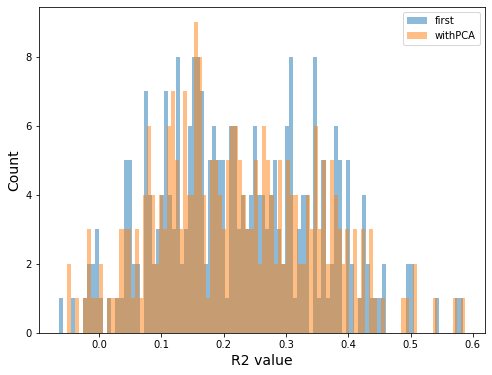

Average r2 across all 265 drug models with reduced data: 0.22012428738797846
Average r2 across all 265 drug models with reduced data and tissue information: 0.2157272555651142


In [106]:
# plot_histograms(list(pcatest_scores.values()), list(pcaclf_test_scores.values()))

plt.figure(figsize=(8,6))
plt.hist(list(xs_test.values()), bins=100, alpha=0.5, label="first")
plt.hist(list(pcatest_scores.values()), bins=100, alpha=0.5, label="withPCA")
plt.xlabel("R2 value", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()
print(f'Average r2 across all 265 drug models with reduced data: {np.mean(list(pcatest_scores.values()))}')
print(f'Average r2 across all 265 drug models with reduced data and tissue information: {np.mean(list(pca_tissue_test.values()))}')


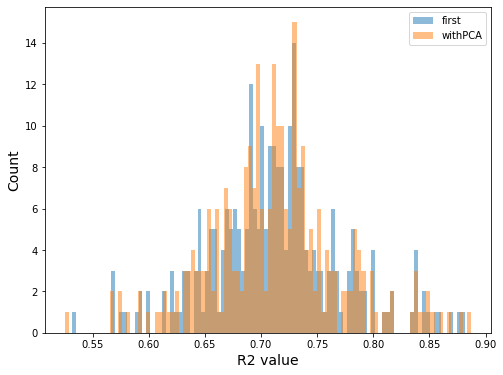

Average accuracy across all 265 drug models with reduced data: 0.7124761061082282
Average accuracy across all 265 drug models with reduced data and tissue information: 0.7140045104816958


In [107]:
# plot_histograms(list(pcatest_scores.values()), list(pcaclf_test_scores.values()))

plt.figure(figsize=(8,6))
plt.hist(list(xs_clf.values()), bins=100, alpha=0.5, label="first")
plt.hist(list(pcaclf_test_scores.values()), bins=100, alpha=0.5, label="withPCA")
plt.xlabel("R2 value", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()
print(f'Average accuracy across all 265 drug models with reduced data: {np.mean(list(pcaclf_test_scores.values()))}')
print(f'Average accuracy across all 265 drug models with reduced data and tissue information: {np.mean(list(pca_tissue_clf.values()))}')


## Part 2 summary: 
### I added the tissue information to the processed data from part 1. The tissue information was added as a one hot encoding to the pca-transformed data. Although the average r2, calculated across all drug models, did not improve with the additional tissue information, the classification accuracy slightly improved.

## Part 3a: Develop a version of your model that can rank order the drugs for a given Cell Line.

I modify my `fully_train_and_evaluate` method so that it returns the best estimator for each drug model. Then I calculate all drug IC50 values for each cell line. With these results, I test a drug sensitivity scoring method to score the cell line drug combinations based on predicted IC50 and the r2 of each drug model. For this method, I sum the IC50 prediction and the r2 value of the model. I do this to push predictions higher in the sensitivity ranking if the model is more performant. However, this ended up being less predictive than just the predicted IC50, so I used the predicted IC50 to get the top 10 drugs (based on sensitivity, smaller IC50 values means better). Then I made a scoring scheme to compare the "true order" with my "predicted order". I iterate the true ordered list and check whether the drug is within 3 places in the predicted order list. This allows some flexibility in the place of the drug within the list.

In [128]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# revamped method so that I can rank order the drugs for each cell line
def fully_train_and_evaluate(scoring, data, model, param_grid, drugs):
    '''Fine-tuning, training, and evaluating all-in-one'''
    test_scores = {}
    train_scores = {}
    best_estimator = {}
    clf_test_scores = {}

    for i, drug in enumerate(drugs):
#         print(f'Drug {i+1}, Drug id {drug}')
        test_scores[drug] = []
        train_scores[drug] = []
        best_estimator[drug] = []
        clf_test_scores[drug] = []
        
        d = data[data.DRUG_ID == drug].drop('DRUG_ID', axis = 1).reset_index(drop =True)
        X = d.iloc[:,1:]
        y = d.LN_IC50
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=0)
        
        clf = GridSearchCV(model, param_grid, scoring='r2', cv=5, n_jobs=-1)
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_
        best_estimator[drug]=best_model
        y_pred = best_model.predict(X_test)
#         print(clf.best_score_)
        train_scores[drug]=clf.best_score_
        test_scores[drug]=best_model.score(X_test, y_test)

        mean = y.mean()
        std = y.std()
        
        def label(value):
            if value < mean - std:
                return 's'
            elif value > mean + std:
                return 'r'
            else:
                return 'i'
        
        clf_y_pred = list(map(label, y_pred))
        clf_y_test = list(map(label, y_test))
        clf_test_scores[drug]=(accuracy_score(clf_y_test, clf_y_pred))
        
    return train_scores, test_scores, clf_test_scores, best_estimator

drugs = list(ic50_df.DRUG_ID.unique())
model=(Ridge(), {'alpha': np.logspace(3, 6, 15)})
pca_tissue_train, pca_tissue_test, pca_tissue_clf, best_estimators = fully_train_and_evaluate('r2', PCA_with_tissue_merged, model[0], model[1], drugs)

In [252]:
# Prediction value to sensitivity class mapper
def label(value):
    if value < mean - std:
        return 's'
    elif value > mean + std:
        return 'r'
    else:
        return 'i'

In [163]:
# Dataset to use for getting the predictions. Reminder: From the og data, we thresholded the variance such that we 
# remove those with a variance less than 0.5. Then we performed PCA to reduce the dimensions to 500 and finally,
# we added the tissue information.
PCA_with_tissue_merged = xs_pca.merge(tissues, left_on='COSMIC_ID', right_on='COSMIC_ID', how='inner')
PCA_with_tissue_merged = ic50_df.merge(PCA_with_tissue_merged, left_on = 'COSMIC_ID', right_on = 'COSMIC_ID', how='left')
PCA_with_tissue_merged.dropna(axis=0, how='any',inplace=True)
PCA_with_tissue_merged

,COSMIC_ID,DRUG_ID,LN_IC50,0,1,2,3,4,5,6,...,pancreas,prostate,rhabdomyosarcoma,skin_other,soft_tissue_other,stomach,testis,thyroid,urogenital_system_other,uterus
0,924100,1026,0.72,10.471315,12.832015,35.471705,15.701749,-7.623831,7.835479,3.775737,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,924100,1028,2.66,10.471315,12.832015,35.471705,15.701749,-7.623831,7.835479,3.775737,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,924100,1029,3.34,10.471315,12.832015,35.471705,15.701749,-7.623831,7.835479,3.775737,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,924100,1030,5.16,10.471315,12.832015,35.471705,15.701749,-7.623831,7.835479,3.775737,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,924100,1031,-4.33,10.471315,12.832015,35.471705,15.701749,-7.623831,7.835479,3.775737,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225395,909907,1053,1.28,-10.339349,31.943581,24.876818,18.519268,-0.249606,1.094017,3.348234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225396,909907,1054,5.48,-10.339349,31.943581,24.876818,18.519268,-0.249606,1.094017,3.348234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225397,909907,1057,-0.14,-10.339349,31.943581,24.876818,18.519268,-0.249606,1.094017,3.348234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225398,909907,1058,1.25,-10.339349,31.943581,24.876818,18.519268,-0.249606,1.094017,3.348234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [276]:
# This gets the ic50 predictions for all drugs for each cell line.

def get_predictions_for_all_combos():
    res = {}
    for i, cosmic_id in enumerate(PCA_with_tissue_merged.COSMIC_ID.unique()):
        cell_line_features = PCA_with_tissue_merged[PCA_with_tissue_merged.COSMIC_ID==cosmic_id].iloc[0,3:]
        res[cosmic_id]=[]
        for drug_id, estimator in best_estimators.items():


            if cosmic_id in list(ic50_df[ic50_df.DRUG_ID==drug_id].COSMIC_ID):

                cell_line_true = ic50_df[(ic50_df.COSMIC_ID==cosmic_id) & (ic50_df.DRUG_ID==drug_id)].LN_IC50.values[0]
                y_pred = estimator.predict([cell_line_features])
                r2_score = pca_tissue_test[drug_id]

                clf_y_pred = label(y_pred)
                clf_y_test = label(cell_line_true)

                acc_score = accuracy_score([clf_y_test], [clf_y_pred])

                res[cosmic_id].append((drug_id, y_pred[0],cell_line_true, clf_y_pred, clf_y_test, r2_score))
            else:
                pass
    return res

res = get_predictions_for_all_combos()

In [258]:
# mapping the prediction to a sensitivity score based on the prediction and the r2 of the model
ex = list(map(lambda x: (x[0], x[1]+x[5], x[2], x[3], x[4], x[5]), res[906832]))
rawpred_based =sorted(res[906832], key=lambda x: x[1])
adjustedpred_based = sorted(ex, key=lambda x: x[1])
true_order = sorted(res[906832], key=lambda x: x[2])

In [275]:

def score_rank_ordered_lst(truth, rank_ordered_lst):
    similarity = []
    for i, el in enumerate(truth):
        # Checks whether the drug is within three places of the truth ranking.
        start = i-3
        stop = i+3

        if start < 0:
            z = rank_ordered_lst[:stop]
        elif stop > len(true_order):
            z = rank_ordered_lst[start:]
        else:
            z = rank_ordered_lst[start:stop]

        l = [val[0] for val in z]
        if el[0] in l:
            similarity.append(True)
        else:
            similarity.append(False)

    return np.mean(similarity)
  
print(f'Comparative score for the raw predictions and the truth: {score_rank_ordered_lst(true_order, rawpred_based)}')
print(f'Comparative score for the scored predictions and the truth: {score_rank_ordered_lst(true_order, adjustedpred_based)}')

Comparative score for the raw predictions and the truth: 0.125
Comparative score for the scored predictions and the truth: 0.12096774193548387


### Above is an example of the scores for comparing the predicted top 10 list with the ground truth. The comparative score for the adjusted prediction list that depends on the prediction and the r2 of the drug model was typically lower or very similar, so I continued with just the raw predictions for the top 10 lists.

In [260]:
top10 = {}
truth = {}
comparative_scores = {}
for cosmic_id in PCA_with_tissue_merged.COSMIC_ID.unique():
    top10[cosmic_id]=sorted(res[cosmic_id], key=lambda x: x[1])[:10]
    truth[cosmic_id] = sorted(res[cosmic_id], key=lambda x: x[2])[:10]
    comparative_scores[cosmic_id] = score_rank_ordered_lst(truth[cosmic_id], top10[cosmic_id])
# comparative_scores


In [268]:
ten = pd.DataFrame()
for k, v in top10.items():
    lst = [el[0] for el in v]
    if len(lst) < 10:
        ten[k] = lst+[float("NaN")]*(10 - len(lst))
    else:
        ten[k]=lst
    
ten

,924100,910924,687561,1287381,910922,905947,1287706,687452,906798,906797,...,924248,909747,687586,687457,909907,909785,909904,909905,687592,946358
0,1007,1007,1007,201,201,201,1007,1007,1494,201,...,104,201,201,1007,1007,104,1007,1007,1007,104
1,268,201,1004,1007,135,1494,1372,201,1007,1007,...,201,1007,1007,201,1031,1003,201,1004,201,1004
2,201,1494,201,180,1494,268,1004,1494,201,1494,...,140,180,1494,1494,1004,1004,1494,1494,1004,1003
3,1494,140,1494,1004,140,135,201,268,1003,1003,...,180,1494,180,1004,1016,140,140,1003,180,1494
4,180,1004,1003,1003,180,180,1494,1003,268,268,...,283,1372,1004,140,1057,283,1003,1031,1494,1248
5,283,180,1248,140,197,140,140,140,1004,180,...,194,200,1003,180,1494,201,268,283,140,201
6,140,1003,1031,197,200,1057,1003,180,180,1004,...,197,197,140,1003,1003,1007,180,268,1031,283
7,1004,197,140,1031,194,197,180,1004,140,140,...,200,140,1031,197,1026,268,1372,1016,1003,1007
8,1003,200,268,136,283,200,1060,194,1031,135,...,346,268,1057,1031,1166,1494,1004,1057,1248,1016
9,1031,194,283,194,268,194,1031,1031,194,1031,...,11,1003,197,268,1060,1248,194,1166,194,268


### Above are the top ten drugs predicted to be sensitive for each cell line. Each column header denotes a cell line, and the values of the column are the top ten drugs with the top being the drug predicted to be the most sensitive for that cell.

In [274]:
comparative_scores

{924100: 0.7,
 910924: 0.7,
 687561: 0.4,
 1287381: 0.6,
 910922: 0.3,
 905947: 0.6,
 1287706: 0.5,
 687452: 0.7,
 906798: 0.8,
 906797: 0.7,
 906800: 0.4,
 687562: 0.5,
 906795: 0.4,
 924102: 0.8,
 910921: 0.7,
 687563: 0.7,
 910935: 0.3,
 906793: 0.5,
 910784: 0.8,
 906792: 0.7,
 906794: 0.5,
 906804: 0.6,
 910697: 0.7,
 910934: 0.6,
 910851: 0.7,
 910925: 0.6,
 905948: 0.7,
 905949: 0.6,
 684052: 0.7,
 910920: 0.6,
 906791: 0.7,
 905950: 0.5,
 910944: 0.4,
 1295740: 0.8,
 910933: 0.3,
 1295741: 0.9,
 906790: 0.5,
 910687: 0.7,
 910704: 0.7,
 910781: 0.7,
 906765: 0.6,
 1290722: 0.5,
 910702: 0.7,
 753531: 0.5,
 753532: 0.5,
 753533: 0.9,
 910919: 0.3,
 910705: 0.7,
 906746: 0.5,
 924104: 0.8,
 906763: 0.5,
 753616: 0.5,
 910926: 0.8,
 910698: 0.9,
 906696: 0.3,
 753535: 0.6,
 1290724: 0.7,
 753534: 0.9,
 1240121: 0.4,
 1290725: 0.9,
 1240122: 0.5,
 910706: 0.5,
 906801: 0.6,
 946359: 0.5,
 949093: 0.4,
 905951: 0.9,
 910710: 0.4,
 924105: 0.6,
 906830: 0.6,
 910850: 0.8,
 906693: 0.

### Above are the scores for comparing my rank ordered list to the rank ordering of IC50 from the Drug Response Data. Closer to 1 means higher similarity.

## Part 3 summary: 
### Although some drug models perform worse than others, the sensitivity rank ordered top 10 lists were fairly comparable to the ground truth in the Drug Response Data. With more time, the models and data could be improved; however, surprisingly, the SIR classifications performed well (~.7 in accuracy) and perhaps even better than the regression (although not directly comparable). 